# Adversarial Discriminative Domain Adaptation (ADDA)

In [1]:
# Dataset
from utils.modules_pbashivan import load_bashivan_data
from utils.modules_pbashivan import get_subject_indices

#Leave one subject cross valdiation
from utils.utils import split_losocv

import numpy as np
import random

# Dataset and Dataloader
from torch.utils.data import TensorDataset, DataLoader


# Save arguments
import argparse

# Torch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

#Model and loss
from models.model_base import RecResNet
from utils.utils import set_requires_grad
#from losses.ada import WalkerVisitLosses

#Sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import warnings


warnings.simplefilter("ignore")

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--max_iterations', type=int, default=1200)
parser.add_argument('--dir_resume', type=str, default="outputs/resume", help='folder for resume')
parser.add_argument('--batch_size', type=int, default=64, help='batch size')
parser.add_argument('--lr', type=float, default=0.0001, help='learning rate')
parser.add_argument('--epochs', type=int, default=30, help='number of epochs')
parser.add_argument('--seed', type=int, default=223, help='seed')
args = parser.parse_args("")

In [3]:
# set random seeds
np.random.seed(args.seed)
random.seed(args.seed)
#tf.set_random_seed(args.seed)
print("SEED:", args.seed)

SEED: 223


In [4]:
path = '/home/fer2696/Maestria/Taller Macroentrenamiento IA/Taller_Macroentrenamiento IA/Dataset/'

In [5]:
# load data
X, y, subjects = load_bashivan_data(path,
                        n_channels=64, n_windows=7, n_bands=3, generate_images=False,
                        size_image=32, visualize=False)


Loading data from /home/fer2696/Maestria/Taller Macroentrenamiento IA/Taller_Macroentrenamiento IA/Dataset/FeatureMat_timeWin.mat
Data loading complete. Shape is (2670, 1345)
Original data: (2670, 1344) (2670,)
Shape images (2670, 3, 7, 24, 24)


# Model

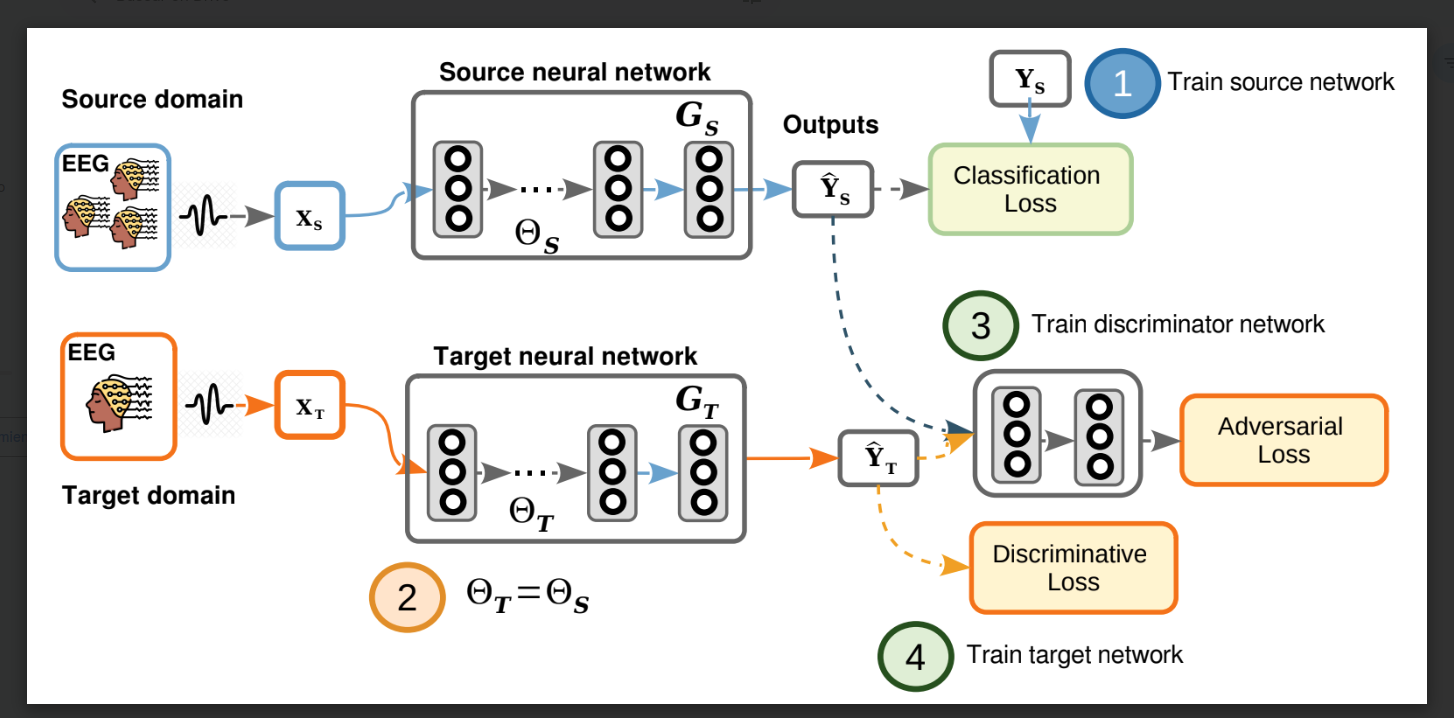

In [6]:
def set_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad


# Train

## Evaluation function

In [7]:
def test(model, test_loader):
    start_test = True
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            # get batch data
            samples = data[0].float().cuda()
            labels = data[1].long().cuda()

            # Get features and predictions
            preds = model(samples)
            # probabilidad máxima
            predictions = preds.data.max(1)[1]

            if start_test:
                y_pred = predictions.cpu().numpy()
                y_true = labels.data.cpu().numpy()
                start_test = False
            else:
                y_pred = np.concatenate((y_pred, predictions.cpu().numpy()), 0)
                y_true = np.concatenate((y_true, labels.data.cpu().numpy()), 0)

        # Binarize ytest with shape (n_samples, n_classes)
        labels = np.unique(y_true)
        ytest = label_binarize(y_true, classes=labels)
        ypreds = label_binarize(y_pred, classes=labels)

        # compute utils
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        auc = roc_auc_score(ytest, ypreds, average='macro', multi_class='ovr')


    return acc, f1, auc


In [8]:
def losocv(X, Y, subjects, args):
    """
        Leave One-Subject-Out Cross-Validation (LOOCV) on Cognitive Load data

        Params
            X: dataset containing all subject samples
            Y: dataset containing all subject labels
            subjects: dataset containing pairs between sample indexes and subjects
            args: hyper-parameters to train Custom Domain Adaptation.
    """

    # variable used to save accuracy results
    list_metrics_clsf = []
        
    # Extract pairs between indexes and subjects
    fold_pairs = get_subject_indices(subjects)
    
    # Iterate over fold_pairs
    for foldNum, fold in enumerate(fold_pairs):
        print('Beginning fold {0} out of {1}'.format(foldNum+1, len(fold_pairs)))

        # Only Subjects 1 and 2 are executed
        if foldNum + 1 >= 3:
            continue

        # Get source and target datasets
        (x_src, y_src), (x_trg, y_trg), y_classes = split_losocv(X, Y, fold)

        # data shape
        print("x_src-shape:", x_src.shape, "y_src-shape:", y_src.shape)
        print("x_trg-shape:", x_trg.shape, "y_trg-shape:", y_trg.shape)
        print("classes:", y_classes)

        # [NUMPY TO TENSOR]
        Sx_tensor = torch.tensor(x_src)
        Sy_tensor = torch.tensor(y_src)
        Tx_tensor = torch.tensor(x_trg)
        Ty_tensor = torch.tensor(y_trg)

        # [CONTAINERS]
        # create container for source labeled data
        source = TensorDataset(Sx_tensor, Sy_tensor)
        # create container for labeled target data
        target = TensorDataset(Tx_tensor, Ty_tensor)

        # [BUILD DATA LOADERS]
        # target
        source_loader = DataLoader(source, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
        target_loader = DataLoader(target, batch_size=args.batch_size, shuffle=True, num_workers=4, drop_last=True)
        test_loader = DataLoader(target, batch_size=args.batch_size, shuffle=False, num_workers=4)

        # counter
        epoch = 1
        eval_iter = x_src.shape[0] // args.batch_size # evaluate each 'eva_iter'

        # [Build Model]
        source_model = RecResNet(n_classes=4).cuda()
        source_model.load_state_dict(torch.load("./trained_model/source" + str(foldNum+1) + ".pt"))
        source_model.eval()
        set_requires_grad(source_model, requires_grad=False)

        # [Target model]
        target_model = RecResNet(n_classes=4).cuda()
        target_model.load_state_dict(torch.load("./trained_model/source" + str(foldNum+1) + ".pt"))

        # Create adversarial discriminator
        discriminator = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        ).cuda()

        # [OPTIMIZERS]
        optimizer_disc = torch.optim.SGD(discriminator.parameters(), lr=args.lr, momentum=0.9, nesterov=True)
        optimizer_target = torch.optim.SGD(target_model.parameters(), lr=args.lr, momentum=0.9, nesterov=True)

        # [Binary Cross-entropy]
        bce_loss = nn.BCEWithLogitsLoss()

        # length of datasets
        len_train_source = len(source_loader)
        len_train_target = len(target_loader)

        # Almacenar pérdida
        list_loss = []
        total_loss = 0
        source_model.eval()

        for iter_num in range(0, args.max_iterations + 1):
            target_model.train()
            discriminator.train()
            # Update loaders
            if iter_num % len_train_source == 0:
                data_iter_s = iter(source_loader)
            if iter_num % len_train_target == 0:
                data_iter_t = iter(target_loader)

            # get batch
            inputs_source, labels_source = next(data_iter_s)
            inputs_target, _ = next(data_iter_t)

            # TO CUDA
            inputs_source, inputs_target, labels_source = inputs_source.float().cuda(), inputs_target.float().cuda(), labels_source.long().cuda()

            # Train discriminator
            set_requires_grad(target_model, requires_grad=False)
            set_requires_grad(discriminator, requires_grad=True)

            # get predictions
            source_preds = source_model(inputs_source)
            target_preds = target_model(inputs_target)

            # combine predictions
            discriminator_x = torch.cat([source_preds, target_preds])
            # generate domain labels
            discriminator_y = torch.cat([torch.ones(inputs_source.shape[0]), torch.zeros(inputs_target.shape[0])]).cuda()
            # apply discriminator
            preds = discriminator(discriminator_x).squeeze()
            # [adversarial loss]
            loss = bce_loss(preds, discriminator_y)


            optimizer_disc.zero_grad()
            loss.backward()
            optimizer_disc.step()

            total_loss += loss.item()

            # Train classifier
            set_requires_grad(target_model, requires_grad=True)
            set_requires_grad(discriminator, requires_grad=False)

            # generate predictions
            target_preds = target_model(inputs_target)

            # flipped labels
            discriminator_y = torch.ones(inputs_target.shape[0]).cuda()

            # get domain predictions
            preds = discriminator(target_preds).squeeze()

            # [binary cross-entropy loss]
            loss = bce_loss(preds, discriminator_y)

            optimizer_target.zero_grad()
            loss.backward()
            optimizer_target.step()

            # append loss
            list_loss.append(loss.cpu().detach().numpy())

            # [EVALUATION]
            if iter_num % int(eval_iter) == 0 and iter_num > 0:
                target_model.eval()
                discriminator.eval()
                acc, f1, auc = test(target_model, test_loader)

                avg_loss = np.array(list_loss).mean()
                print('Epoch: %d loss: %4f Acc: %.4f  F1-score: %.4f  AUC: %.4f' % (epoch, avg_loss, acc, f1, auc))
                epoch += 1

                total_loss = 0
                list_loss = []

        print("\n")
        # add to list
        list_metrics_clsf.append([acc, f1, auc, foldNum+1])
    
    # To np array
    list_metrics_clsf = np.array(list_metrics_clsf)

    # Save Classification Metrics
    save_file = args.dir_resume+"/losocv-results.csv"
    f=open(save_file, 'ab')
    np.savetxt(f, list_metrics_clsf, delimiter=",", fmt='%0.4f')
    f.close()

In [9]:
# run Leave One-Subject-Out Cross-Validation (LOSOCV)
losocv(X, y, subjects, args)

Beginning fold 1 out of 13
x_src-shape: (2485, 3, 7, 24, 24) y_src-shape: (2485,)
x_trg-shape: (185, 3, 7, 24, 24) y_trg-shape: (185,)
classes: [0 1 2 3]
Epoch: 1 loss: 0.904785 Acc: 0.5784  F1-score: 0.5245  AUC: 0.7090
Epoch: 2 loss: 0.831114 Acc: 0.5730  F1-score: 0.5218  AUC: 0.7053
Epoch: 3 loss: 0.781726 Acc: 0.5622  F1-score: 0.5122  AUC: 0.6981
Epoch: 4 loss: 0.749411 Acc: 0.5514  F1-score: 0.5025  AUC: 0.6910
Epoch: 5 loss: 0.726230 Acc: 0.5405  F1-score: 0.4956  AUC: 0.6839
Epoch: 6 loss: 0.709344 Acc: 0.5459  F1-score: 0.5020  AUC: 0.6876
Epoch: 7 loss: 0.696002 Acc: 0.5405  F1-score: 0.4985  AUC: 0.6841
Epoch: 8 loss: 0.686861 Acc: 0.5459  F1-score: 0.5116  AUC: 0.6880
Epoch: 9 loss: 0.676585 Acc: 0.5459  F1-score: 0.5132  AUC: 0.6881
Epoch: 10 loss: 0.670100 Acc: 0.5243  F1-score: 0.4972  AUC: 0.6740
Epoch: 11 loss: 0.662898 Acc: 0.5243  F1-score: 0.5075  AUC: 0.6743
Epoch: 12 loss: 0.658334 Acc: 0.6162  F1-score: 0.6062  AUC: 0.7329
Epoch: 13 loss: 0.652757 Acc: 0.6108  F

## Open results in csv

In [10]:
import pandas as pd

df = pd.read_csv(args.dir_resume + "/losocv-results.csv")
print(df.to_string()) 

    0.5892  0.5357  0.7163  1.0000
0   0.7358  0.6864  0.8225     2.0
1   0.8744  0.8784  0.9204     3.0
2   1.0000  1.0000  1.0000     4.0
3   1.0000  1.0000  1.0000     5.0
4   0.9950  0.9952  0.9970     6.0
5   0.9948  0.9948  0.9969     7.0
6   1.0000  1.0000  1.0000     8.0
7   0.9952  0.9957  0.9970     9.0
8   0.9911  0.9909  0.9943    10.0
9   0.9631  0.9620  0.9754    11.0
10  0.7129  0.6804  0.8180    12.0
11  0.4773  0.4442  0.6700    13.0
12  0.8486  0.8359  0.8889     1.0
13  0.9151  0.9043  0.9362     2.0
